<a href="https://colab.research.google.com/github/Tina0330/Tina0330/blob/main/Large_Text_Similarity_with_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test Efficiency of power of GPU in Google Colab

Two APIs performance will be tested and measured:
1. Tensorflow USE -- Sentence Embedding
2. FAISS -- similarity search

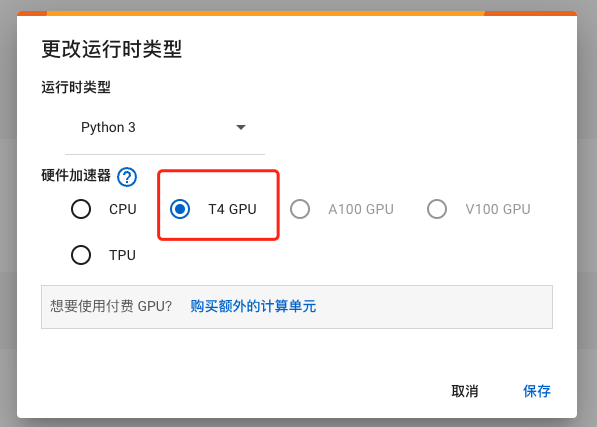

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Dependency

In [2]:
import numpy as np
import os
import pandas as pd
import re


In [3]:
pwd

'/content'

In [4]:
df = pd.read_csv("Spotify Million Song Dataset_exported.csv")
df.head(3)

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...


In [5]:
df.shape

(57650, 4)

In [6]:
#@title Load the Universal Sentence Encoder's TF Hub module
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  input = [input]
  res = model(input)
  vec = res.numpy()
  return vec

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [18]:
# word = "Elephant"
# sentence = "I am a sentence for which I would like to get its embedding."
# paragraph = (
#     "Universal Sentence Encoder embeddings also support short paragraphs. "
#     "There is no hard limit on how long the paragraph is. Roughly, the longer "
#     "the more 'diluted' the embedding will be.")
# messages = [word, sentence, paragraph]

In [22]:
%%time
### Running ENV: GPU
df['Embedding'] = df['text'].apply(embed)

CPU times: user 8min 59s, sys: 59 s, total: 9min 58s
Wall time: 7min 12s


In [ ]:
### switch env to CPU and check time consumption

In [26]:
%%time
### Running ENV: CPU
df['Embedding'] = df['text'].apply(embed)

CPU times: user 6min 18s, sys: 15.6 s, total: 6min 33s
Wall time: 6min 15s


In [ ]:
print("Summary for Sentence Embedding")
print("GPU Embedding ",df.shape, "Time Consumed: 7min 12s")
print("CPU Embedding ",df.shape, "Time Consumed: 6min 15s")

## FAISS

In [10]:
# For CPU
!apt install libomp-dev
!pip install faiss-cpu

# For GPU
# !pip install faiss-gpu

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libomp-dev is already the newest version (1:14.0-55~exp2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 59.5 MB/s eta 0:00:00


In [11]:
df.head()

,artist,song,link,text,Embedding
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd...","((tf.Tensor(-0.008617841, shape=(), dtype=floa..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl...","((tf.Tensor(-0.056036953, shape=(), dtype=floa..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...,"((tf.Tensor(-0.04497896, shape=(), dtype=float..."
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...,"((tf.Tensor(0.0125936335, shape=(), dtype=floa..."
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...,"((tf.Tensor(0.009847095, shape=(), dtype=float..."


### GPU- Faiss

In [14]:
##For GPU
!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 10.3 MB/s eta 0:00:00


In [15]:
import faiss


In [16]:
## GPU Usage
result = faiss.StandardGpuResources()  # use a single GPU
d = 512
# build a flat (CPU) index
index_flat = faiss.IndexFlatL2(d)
# make it into a gpu index
gpu_index_flat = faiss.index_cpu_to_gpu(result, 0, index_flat)


In [17]:
base_matrix = np.concatenate(df["Embedding"].values, axis = 0)
base_matrix.shape

gpu_index_flat.add(base_matrix)         # add vectors to the index
print(gpu_index_flat.ntotal)

57650


In [19]:
k = 10

In [20]:
%%time
## search similar items from same dataframe
res_index = []
scr_lst = []
for item in df['Embedding']:
  res = gpu_index_flat.search(item,k)
  simi_index = res[1][0].tolist()
  scr = res[0][0].tolist()
  res_index.append(simi_index)
  scr_lst.append(scr)

df['SIMI_IND'] = res_index
df['SIMI_SCR'] = scr_lst


CPU times: user 43.5 s, sys: 87.8 ms, total: 43.6 s
Wall time: 45.3 s


### CPU - Faiss

In [12]:
a = torch.tensor([[1.,2,3],[4,5,6]], device='cuda')

In [29]:
base_matrix = np.concatenate(df["Embedding"].values, axis = 0)
base_matrix.shape

(57650, 512)

In [30]:
## build index
d = 512
k = 10
index = faiss.IndexFlatL2(d)
## add base vector to faiss
index.add(base_matrix)

In [32]:
%%time
## search similar items from same dataframe
res_index = []
scr_lst = []
for item in df['Embedding']:
  res = index.search(item,k)
  simi_index = res[1][0].tolist()
  scr = res[0][0].tolist()
  res_index.append(simi_index)
  scr_lst.append(scr)

df['SIMI_IND'] = res_index
df['SIMI_SCR'] = scr_lst


CPU times: user 14min 2s, sys: 935 ms, total: 14min 3s
Wall time: 14min 15s


### Summary

In [21]:
print("Summary for Similarity Search")
print("GPU Search ",df.shape, "Time Consumed: 14min 15s")
print("CPU Search ",df.shape, "Time Consumed: 45.3s")

Summary for Similarity Search
GPU Search  (57650, 7) Time Consumed: 14min 15s
CPU Search  (57650, 7) Time Consumed: 45.3s


**Conclusion:**
- For sentence embedding, CPU outperforms GPU by 1 mins faster.
- For similarity search, faiss-gpu works much faster than faiss-cpu by costing only 45 seconds versus 14mins.